# Approach 3: Traditional Transfer Learning

## Pre-train on PASTIS → Fine-tune on Algerian

**Purpose**: Compare traditional transfer learning vs. FDA domain adaptation.

### Key Differences from Approach 1:
- **Phase 1**: Pre-train on raw PASTIS data (French domain)
- **Phase 2**: Fine-tune on Algerian training data (target domain)
- **No FDA adaptation**: Tests traditional transfer learning approach
- **Domain gap**: French → Algerian satellite imagery differences

### Data Summary:
- **PASTIS Pre-training**: 2,433 raw French samples
- **Algerian Fine-tuning**: 101 real Algerian training samples
- **Algerian Validation**: 92 real Algerian validation samples
- **Input Shape**: (10, 128, 128) - 10 Sentinel-2 bands
- **Challenge**: Domain shift between French and Algerian imagery

In [1]:
# =============================================================================
# CELL 1: Imports and Setup
# =============================================================================

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, WeightedRandomSampler
import numpy as np
from pathlib import Path
import matplotlib.pyplot as plt
from tqdm import tqdm
import random
from collections import defaultdict
import warnings
warnings.filterwarnings('ignore')

# Check for GPU
def get_device():
    if torch.cuda.is_available():
        try:
            test_tensor = torch.zeros(1).cuda()
            del test_tensor
            torch.cuda.empty_cache()
            return torch.device('cuda')
        except RuntimeError as e:
            print(f"⚠️ CUDA available but not compatible: {e}")
            return torch.device('cpu')
    return torch.device('cpu')

device = get_device()
print(f"Using device: {device}")

if device.type == 'cuda':
    print(f"GPU: {torch.cuda.get_device_name(0)}")
    print(f"Memory: {torch.cuda.get_device_properties(0).total_memory / 1e9:.1f} GB")

# Set seeds for reproducibility
def set_seed(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(seed)

set_seed(42)

Using device: cuda
GPU: NVIDIA GeForce RTX 5090
Memory: 33.7 GB


In [2]:
# =============================================================================
# CELL 2: Data Paths and Configuration
# =============================================================================

# Data directories - using ORIGINAL PASTIS data (not FDA-adapted)
PASTIS_DATA_DIR = Path('/home/crop/Desktop/crop2/output/pastis_maxndvi/DATA_S2')
PASTIS_ANN_DIR = Path('/home/crop/Desktop/crop2/output/pastis_maxndvi/ANNOTATIONS')

ALGERIA_DATA_DIR = Path('/home/crop/Desktop/crop2/output/algeria_s2_data/DATA_S2')
ALGERIA_ANN_DIR = Path('/home/crop/Desktop/crop2/output/algeria_s2_data/ANNOTATIONS')

# Training configuration
CONFIG = {
    'batch_size': 16,
    'pastis_lr': 1e-4,      # Learning rate for PASTIS pre-training
    'finetune_lr': 1e-5,    # Lower learning rate for fine-tuning
    'weight_decay': 0.01,
    'pastis_epochs': 15,    # Pre-training epochs on PASTIS
    'finetune_epochs': 15,  # Fine-tuning epochs on Algerian
    'num_workers': 4,
    'img_size': 128,
    'in_channels': 10,
    'num_classes': 1,
    'parcel_threshold': 0.3,  # For PASTIS labeling
    'prediction_threshold': 0.4,  # Lower threshold for binary classification
}

print("Configuration:")
for k, v in CONFIG.items():
    print(f"  {k}: {v}")

print(f"\n⚠️  TRADITIONAL TRANSFER LEARNING:")
print("   Phase 1: Pre-train on raw PASTIS data")
print("   Phase 2: Fine-tune on Algerian training data")
print("   No FDA adaptation applied")

Configuration:
  batch_size: 16
  pastis_lr: 0.0001
  finetune_lr: 1e-05
  weight_decay: 0.01
  pastis_epochs: 15
  finetune_epochs: 15
  num_workers: 4
  img_size: 128
  in_channels: 10
  num_classes: 1
  parcel_threshold: 0.3
  prediction_threshold: 0.4

⚠️  TRADITIONAL TRANSFER LEARNING:
   Phase 1: Pre-train on raw PASTIS data
   Phase 2: Fine-tune on Algerian training data
   No FDA adaptation applied


## Step 1: Dataset Classes

Using original PASTIS data with parcel coverage labeling + real Algerian data.

In [3]:
# =============================================================================
# CELL 3: Dataset Classes
# =============================================================================

class PASTISDataset(Dataset):
    """
    Original PASTIS Dataset (French data, no FDA adaptation)
    - Uses raw French spectral characteristics
    - Labels based on parcel coverage (same as before)
    """
    
    def __init__(self, data_dir, ann_dir, parcel_threshold=0.3, transform=None):
        self.data_dir = Path(data_dir)
        self.ann_dir = Path(ann_dir)
        self.parcel_threshold = parcel_threshold
        self.transform = transform
        
        # Get all data files
        self.data_files = sorted(self.data_dir.glob('*.npy'))
        
        # Filter to only include files with matching annotations
        self.samples = []
        for data_file in self.data_files:
            file_id = data_file.stem.replace('S2_', '')
            
            possible_ann_names = [
                f'ParcelIDs_{file_id}.npy',
                f'TARGET_{file_id}.npy',
                data_file.name,
            ]
            
            ann_file = None
            for ann_name in possible_ann_names:
                candidate = self.ann_dir / ann_name
                if candidate.exists():
                    ann_file = candidate
                    break
            
            if ann_file is not None:
                self.samples.append((data_file, ann_file))
        
        print(f"PASTIS Dataset: {len(self.samples)} samples loaded")
        
        if len(self.samples) > 0:
            self._compute_class_distribution()
    
    def _compute_class_distribution(self):
        crop_count = 0
        non_crop_count = 0
        
        for _, ann_file in self.samples[:100]:
            ann = np.load(ann_file)
            parcel_coverage = (ann > 0).sum() / ann.size
            
            if parcel_coverage >= self.parcel_threshold:
                crop_count += 1
            else:
                non_crop_count += 1
        
        print(f"  Distribution (threshold={self.parcel_threshold}): Crop={crop_count}, Non-crop={non_crop_count}")
    
    def __len__(self):
        return len(self.samples)
    
    def __getitem__(self, idx):
        data_file, ann_file = self.samples[idx]
        
        img = np.load(data_file)[0].astype(np.float32)
        img = img / 10000.0
        img = np.clip(img, 0, 1)
        
        ann = np.load(ann_file)
        parcel_coverage = (ann > 0).sum() / ann.size
        label = 1.0 if parcel_coverage >= self.parcel_threshold else 0.0
        
        img = torch.from_numpy(img)
        label = torch.tensor(label, dtype=torch.float32)
        
        if self.transform:
            img = self.transform(img)
        
        return img, label


class AlgeriaDataset(Dataset):
    """
    Real Algerian Dataset - Ground truth labels
    """
    
    def __init__(self, data_dir, ann_dir, split='train', transform=None):
        self.data_dir = Path(data_dir)
        self.ann_dir = Path(ann_dir)
        self.split = split
        self.transform = transform
        
        # Load split mapping
        metadata_path = self.data_dir.parent / 'metadata.geojson'
        split_map = {}
        
        if metadata_path.exists():
            import json
            with open(metadata_path, 'r') as f:
                metadata = json.load(f)
            for feature in metadata['features']:
                filename = feature['properties']['filename']
                file_split = feature['properties']['split']
                split_map[filename] = file_split
        
        # Get all data files
        self.data_files = sorted(self.data_dir.glob('*.npy'))
        
        # Filter by split
        self.samples = []
        for data_file in self.data_files:
            file_split = split_map.get(data_file.name, None)
            if split == 'val' and file_split == 'validation':
                pass
            elif file_split == split:
                pass
            else:
                continue
            
            file_id = data_file.stem.replace('S2_', '')
            ann_file = self.ann_dir / f'Labels_{file_id}.npy'
            if ann_file.exists():
                self.samples.append((data_file, ann_file))
        
        print(f"AlgeriaDataset ({split}): {len(self.samples)} samples")
        
        if len(self.samples) > 0:
            self._compute_class_distribution()
    
    def _compute_class_distribution(self):
        cereal_count = 0
        non_cereal_count = 0
        
        for _, ann_file in self.samples:
            ann = np.load(ann_file)
            label = float(ann.max()) if ann.ndim > 0 else float(ann)
            if label == 1:
                cereal_count += 1
            else:
                non_cereal_count += 1
        
        print(f"  Distribution: Cereal={cereal_count}, Non-cereal={non_cereal_count}")
    
    def __len__(self):
        return len(self.samples)
    
    def __getitem__(self, idx):
        data_file, ann_file = self.samples[idx]
        
        img = np.load(data_file)[0].astype(np.float32)
        img = img / 10000.0
        img = np.clip(img, 0, 1)
        
        ann = np.load(ann_file)
        label = float(ann.max()) if ann.ndim > 0 else float(ann)
        
        img = torch.from_numpy(img)
        label = torch.tensor(label, dtype=torch.float32)
        
        if self.transform:
            img = self.transform(img)
        
        return img, label

In [4]:
# =============================================================================
# CELL 4: Data Augmentation
# =============================================================================

class RandomFlip:
    def __call__(self, img):
        if random.random() > 0.5:
            img = torch.flip(img, dims=[2])
        if random.random() > 0.5:
            img = torch.flip(img, dims=[1])
        return img

class RandomRotation90:
    def __call__(self, img):
        k = random.randint(0, 3)
        return torch.rot90(img, k, dims=[1, 2])

class RandomNoise:
    def __init__(self, std=0.01):
        self.std = std
    
    def __call__(self, img):
        if random.random() > 0.5:
            noise = torch.randn_like(img) * self.std
            img = torch.clamp(img + noise, 0, 1)
        return img

class Compose:
    def __init__(self, transforms):
        self.transforms = transforms
    
    def __call__(self, img):
        for t in self.transforms:
            img = t(img)
        return img

# Define transforms
pastis_transform = Compose([
    RandomFlip(),
    RandomRotation90(),
    RandomNoise(std=0.01),
])

algeria_transform = Compose([
    RandomFlip(),
    RandomRotation90(),
    RandomNoise(std=0.005),  # Less noise for fine-tuning
])

val_transform = None

print("✓ Data augmentation defined")

✓ Data augmentation defined


In [5]:
# =============================================================================
# CELL 5: Initialize Datasets and Loaders
# =============================================================================

print("Loading datasets...")
print("-" * 50)

# PASTIS dataset for pre-training
pastis_dataset = PASTISDataset(
    data_dir=PASTIS_DATA_DIR,
    ann_dir=PASTIS_ANN_DIR,
    parcel_threshold=CONFIG['parcel_threshold'],
    transform=pastis_transform
)

# Algerian datasets
algeria_train_dataset = AlgeriaDataset(
    data_dir=ALGERIA_DATA_DIR,
    ann_dir=ALGERIA_ANN_DIR,
    split='train',
    transform=algeria_transform
)

algeria_val_dataset = AlgeriaDataset(
    data_dir=ALGERIA_DATA_DIR,
    ann_dir=ALGERIA_ANN_DIR,
    split='val',
    transform=val_transform
)

print("-" * 50)

# Data loaders for traditional transfer learning
pastis_loader = DataLoader(
    pastis_dataset,
    batch_size=CONFIG['batch_size'],
    shuffle=True,
    num_workers=0  # Set to 0 for debugging
)

algeria_train_loader = DataLoader(
    algeria_train_dataset,
    batch_size=CONFIG['batch_size'],
    shuffle=True,
    num_workers=0
)

algeria_val_loader = DataLoader(
    algeria_val_dataset,
    batch_size=CONFIG['batch_size'],
    shuffle=False,
    num_workers=0
)

print(f"PASTIS loader: {len(pastis_loader)} batches ({len(pastis_dataset)} samples)")
print(f"Algerian train loader: {len(algeria_train_loader)} batches ({len(algeria_train_dataset)} samples)")
print(f"Algerian val loader: {len(algeria_val_loader)} batches ({len(algeria_val_dataset)} samples)")

# Verify batch shapes
print("\nVerifying batch shapes...")
for imgs, labels in pastis_loader:
    print(f"PASTIS batch: {imgs.shape}, labels: {labels.tolist()[:5]}...")
    break

for imgs, labels in algeria_train_loader:
    print(f"Algerian train batch: {imgs.shape}, labels: {labels.tolist()[:5]}...")
    break

Loading datasets...
--------------------------------------------------
PASTIS Dataset: 2433 samples loaded
  Distribution (threshold=0.3): Crop=93, Non-crop=7
AlgeriaDataset (train): 101 samples
  Distribution: Cereal=40, Non-cereal=61
AlgeriaDataset (val): 92 samples
  Distribution: Cereal=40, Non-cereal=52
--------------------------------------------------
PASTIS loader: 153 batches (2433 samples)
Algerian train loader: 7 batches (101 samples)
Algerian val loader: 6 batches (92 samples)

Verifying batch shapes...
PASTIS batch: torch.Size([16, 10, 128, 128]), labels: [1.0, 1.0, 1.0, 1.0, 0.0]...
Algerian train batch: torch.Size([16, 10, 128, 128]), labels: [0.0, 1.0, 1.0, 0.0, 1.0]...


## Step 2: Modified Swin Transformer

Same 10-channel architecture for transfer learning.

In [6]:
# =============================================================================
# CELL 6: Swin Transformer with 10-Channel Input
# =============================================================================

import timm

def create_swin_model(in_channels=10, num_classes=1, pretrained=True, img_size=128):
    model = timm.create_model(
        'swin_tiny_patch4_window7_224',
        pretrained=pretrained,
        num_classes=num_classes,
        img_size=img_size,
    )
    
    # Modify patch embedding
    orig_proj = model.patch_embed.proj
    new_proj = nn.Conv2d(
        in_channels=in_channels,
        out_channels=orig_proj.out_channels,
        kernel_size=orig_proj.kernel_size,
        stride=orig_proj.stride,
        padding=orig_proj.padding
    )
    
    with torch.no_grad():
        new_proj.weight[:, :3, :, :] = orig_proj.weight
        for i in range(3, in_channels):
            new_proj.weight[:, i, :, :] = orig_proj.weight.mean(dim=1)
            new_proj.weight[:, i, :, :] += torch.randn_like(new_proj.weight[:, i, :, :]) * 0.01
        new_proj.bias.copy_(orig_proj.bias)
    
    model.patch_embed.proj = new_proj
    
    print(f"Modified patch embedding: {model.patch_embed.proj}")
    return model

# Create model
model = create_swin_model(
    in_channels=CONFIG['in_channels'],
    num_classes=CONFIG['num_classes'],
    pretrained=True,
    img_size=CONFIG['img_size']
).to(device)

total_params = sum(p.numel() for p in model.parameters())
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f"Total parameters: {total_params:,}")
print(f"Trainable parameters: {trainable_params:,}")

Modified patch embedding: Conv2d(10, 96, kernel_size=(4, 4), stride=(4, 4))
Total parameters: 27,525,115
Trainable parameters: 27,525,115


In [7]:
# =============================================================================
# CELL 7: Loss Function and Optimizers
# =============================================================================

# Calculate class weights for PASTIS (more balanced)
pastis_pos_weight = torch.tensor([1.2]).to(device)  # Slightly weighted for PASTIS
pastis_criterion = nn.BCEWithLogitsLoss(pos_weight=pastis_pos_weight)

# Calculate class weights for Algerian (more imbalanced)
algeria_pos_weight = torch.tensor([2.0]).to(device)  # Heavier weight for Algerian
algeria_criterion = nn.BCEWithLogitsLoss(pos_weight=algeria_pos_weight)

# Optimizers for different phases
pastis_optimizer = optim.AdamW(
    model.parameters(),
    lr=CONFIG['pastis_lr'],
    weight_decay=CONFIG['weight_decay']
)

algeria_optimizer = optim.AdamW(
    model.parameters(),
    lr=CONFIG['finetune_lr'],
    weight_decay=CONFIG['weight_decay']
)

# Schedulers
pastis_scheduler = optim.lr_scheduler.CosineAnnealingWarmRestarts(
    pastis_optimizer,
    T_0=5,
    T_mult=2,
    eta_min=1e-6
)

algeria_scheduler = optim.lr_scheduler.CosineAnnealingWarmRestarts(
    algeria_optimizer,
    T_0=5,
    T_mult=2,
    eta_min=1e-7
)

print("Training Configuration:")
print(f"  PASTIS Phase: BCEWithLogitsLoss (pos_weight={pastis_pos_weight.item():.2f})")
print(f"    Optimizer: AdamW (lr={CONFIG['pastis_lr']}, wd={CONFIG['weight_decay']})")
print(f"    Epochs: {CONFIG['pastis_epochs']}")
print(f"  Algerian Phase: BCEWithLogitsLoss (pos_weight={algeria_pos_weight.item():.2f})")
print(f"    Optimizer: AdamW (lr={CONFIG['finetune_lr']}, wd={CONFIG['weight_decay']})")
print(f"    Epochs: {CONFIG['finetune_epochs']}")
print(f"  ⚠️  TRADITIONAL TRANSFER LEARNING:")
print("     Phase 1: Pre-train on PASTIS (French domain)")
print("     Phase 2: Fine-tune on Algerian (target domain)")

Training Configuration:
  PASTIS Phase: BCEWithLogitsLoss (pos_weight=1.20)
    Optimizer: AdamW (lr=0.0001, wd=0.01)
    Epochs: 15
  Algerian Phase: BCEWithLogitsLoss (pos_weight=2.00)
    Optimizer: AdamW (lr=1e-05, wd=0.01)
    Epochs: 15
  ⚠️  TRADITIONAL TRANSFER LEARNING:
     Phase 1: Pre-train on PASTIS (French domain)
     Phase 2: Fine-tune on Algerian (target domain)


In [8]:
# =============================================================================
# CELL 8: Training and Validation Functions
# =============================================================================

def train_epoch(model, train_loader, criterion, optimizer, device, phase_name="Training", threshold=0.5):
    model.train()
    total_loss = 0
    correct = 0
    total = 0
    
    pbar = tqdm(train_loader, desc=phase_name, leave=False)
    
    for imgs, labels in pbar:
        imgs = imgs.to(device)
        labels = labels.to(device).unsqueeze(1)
        
        optimizer.zero_grad()
        outputs = model(imgs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        total_loss += loss.item() * imgs.size(0)
        preds = (torch.sigmoid(outputs) > threshold).float()
        correct += (preds == labels).sum().item()
        total += imgs.size(0)
        
        pbar.set_postfix({
            'loss': f'{loss.item():.4f}',
            'acc': f'{100*correct/total:.1f}%'
        })
    
    avg_loss = total_loss / total
    accuracy = correct / total
    
    return avg_loss, accuracy

def validate(model, val_loader, criterion, device, threshold=0.5):
    model.eval()
    total_loss = 0
    all_preds = []
    all_labels = []
    
    with torch.no_grad():
        for imgs, labels in val_loader:
            imgs = imgs.to(device)
            labels = labels.to(device).unsqueeze(1)
            
            outputs = model(imgs)
            loss = criterion(outputs, labels)
            
            total_loss += loss.item() * imgs.size(0)
            preds = (torch.sigmoid(outputs) > threshold).float()
            all_preds.extend(preds.cpu().numpy().flatten())
            all_labels.extend(labels.cpu().numpy().flatten())
    
    all_preds = np.array(all_preds)
    all_labels = np.array(all_labels)
    
    accuracy = (all_preds == all_labels).mean()
    tp = ((all_preds == 1) & (all_labels == 1)).sum()
    fp = ((all_preds == 1) & (all_labels == 0)).sum()
    fn = ((all_preds == 0) & (all_labels == 1)).sum()
    tn = ((all_preds == 0) & (all_labels == 0)).sum()
    
    precision = tp / max(tp + fp, 1)
    recall = tp / max(tp + fn, 1)
    f1 = 2 * precision * recall / max(precision + recall, 1e-8)
    
    return total_loss / len(all_preds), accuracy, precision, recall, f1, (tp, fp, fn, tn)

print("✓ Training functions defined")

✓ Training functions defined


In [9]:
# =============================================================================
# CELL 9: Two-Phase Training Loop
# =============================================================================

def train_transfer_learning(model, pastis_loader, algeria_train_loader, algeria_val_loader,
                          pastis_criterion, algeria_criterion, pastis_optimizer, algeria_optimizer,
                          pastis_scheduler, algeria_scheduler, device, config):
    
    history = {
        'phase': [],
        'epoch': [],
        'train_loss': [], 'train_acc': [],
        'val_loss': [], 'val_acc': [],
        'val_precision': [], 'val_recall': [], 'val_f1': [],
        'lr': []
    }
    
    best_val_f1 = 0
    best_model_state = None
    global_epoch = 0
    
    print("=" * 80)
    print("TRADITIONAL TRANSFER LEARNING: PASTIS → Algerian")
    print("=" * 80)
    print(f"Phase 1: Pre-train on PASTIS ({len(pastis_loader)} batches, {len(pastis_dataset)} samples)")
    print(f"Phase 2: Fine-tune on Algerian ({len(algeria_train_loader)} batches, {len(algeria_train_dataset)} samples)")
    print(f"Validation: Algerian ({len(algeria_val_dataset)} samples)")
    print()
    
    # ================================
    # PHASE 1: Pre-training on PASTIS
    # ================================
    print("🚀 PHASE 1: Pre-training on PASTIS (French Domain)")
    print("-" * 60)
    
    for epoch in range(config['pastis_epochs']):
        global_epoch += 1
        
        train_loss, train_acc = train_epoch(
            model, pastis_loader, pastis_criterion, pastis_optimizer, device,
            phase_name=f'PASTIS Pre-train {epoch+1}/{config["pastis_epochs"]}',
            threshold=config['prediction_threshold']
        )
        
        val_loss, val_acc, val_prec, val_rec, val_f1, conf_matrix = validate(
            model, algeria_val_loader, algeria_criterion, device,
            threshold=config['prediction_threshold']
        )
        
        pastis_scheduler.step()
        current_lr = pastis_optimizer.param_groups[0]['lr']
        
        history['phase'].append('pastis')
        history['epoch'].append(global_epoch)
        history['train_loss'].append(train_loss)
        history['train_acc'].append(train_acc)
        history['val_loss'].append(val_loss)
        history['val_acc'].append(val_acc)
        history['val_precision'].append(val_prec)
        history['val_recall'].append(val_rec)
        history['val_f1'].append(val_f1)
        history['lr'].append(current_lr)
        
        tp, fp, fn, tn = conf_matrix
        print(f"Epoch {epoch+1}/{config['pastis_epochs']} (PASTIS Pre-train)")
        print(f"  Train Loss: {train_loss:.4f} | Train Acc: {train_acc*100:.1f}%")
        print(f"  Val Loss: {val_loss:.4f} | Val Acc: {val_acc*100:.1f}%")
        print(f"  Val Precision: {val_prec*100:.1f}% | Recall: {val_rec*100:.1f}% | F1: {val_f1*100:.1f}%")
        print(f"  LR: {current_lr:.6f}")
        
        if val_f1 > best_val_f1:
            best_val_f1 = val_f1
            best_model_state = model.state_dict().copy()
            print("  ★ New best F1")
    
    print("\n" + "=" * 60)
    print("Phase 1 Complete - Best F1 on Algerian validation: {:.1f}%".format(best_val_f1*100))
    print("=" * 60)
    
    # ================================
    # PHASE 2: Fine-tuning on Algerian
    # ================================
    print("\n🚀 PHASE 2: Fine-tuning on Algerian (Target Domain)")
    print("-" * 60)
    
    for epoch in range(config['finetune_epochs']):
        global_epoch += 1
        
        train_loss, train_acc = train_epoch(
            model, algeria_train_loader, algeria_criterion, algeria_optimizer, device,
            phase_name=f'Algerian Fine-tune {epoch+1}/{config["finetune_epochs"]}',
            threshold=config['prediction_threshold']
        )
        
        val_loss, val_acc, val_prec, val_rec, val_f1, conf_matrix = validate(
            model, algeria_val_loader, algeria_criterion, device,
            threshold=config['prediction_threshold']
        )
        
        algeria_scheduler.step()
        current_lr = algeria_optimizer.param_groups[0]['lr']
        
        history['phase'].append('algeria')
        history['epoch'].append(global_epoch)
        history['train_loss'].append(train_loss)
        history['train_acc'].append(train_acc)
        history['val_loss'].append(val_loss)
        history['val_acc'].append(val_acc)
        history['val_precision'].append(val_prec)
        history['val_recall'].append(val_rec)
        history['val_f1'].append(val_f1)
        history['lr'].append(current_lr)
        
        tp, fp, fn, tn = conf_matrix
        print(f"Epoch {epoch+1}/{config['finetune_epochs']} (Algerian Fine-tune)")
        print(f"  Train Loss: {train_loss:.4f} | Train Acc: {train_acc*100:.1f}%")
        print(f"  Val Loss: {val_loss:.4f} | Val Acc: {val_acc*100:.1f}%")
        print(f"  Val Precision: {val_prec*100:.1f}% | Recall: {val_rec*100:.1f}% | F1: {val_f1*100:.1f}%")
        print(f"  LR: {current_lr:.6f}")
        
        if val_f1 > best_val_f1:
            best_val_f1 = val_f1
            best_model_state = model.state_dict().copy()
            print("  ★ New best F1")
    
    print("\n" + "=" * 80)
    print("TRANSFER LEARNING COMPLETE")
    print("=" * 80)
    print(f"Best Validation F1: {best_val_f1*100:.1f}%")
    print("Traditional Transfer Learning: PASTIS → Algerian")
    
    if best_model_state:
        model.load_state_dict(best_model_state)
        print("✓ Best model restored")
    
    return history, best_val_f1

print("✓ Two-phase training loop defined")

✓ Two-phase training loop defined


In [10]:
# =============================================================================
# CELL 10: Run Transfer Learning Training
# =============================================================================

# Train the model using traditional transfer learning
history, best_f1 = train_transfer_learning(
    model=model,
    pastis_loader=pastis_loader,
    algeria_train_loader=algeria_train_loader,
    algeria_val_loader=algeria_val_loader,
    pastis_criterion=pastis_criterion,
    algeria_criterion=algeria_criterion,
    pastis_optimizer=pastis_optimizer,
    algeria_optimizer=algeria_optimizer,
    pastis_scheduler=pastis_scheduler,
    algeria_scheduler=algeria_scheduler,
    device=device,
    config=CONFIG
)

TRADITIONAL TRANSFER LEARNING: PASTIS → Algerian
Phase 1: Pre-train on PASTIS (153 batches, 2433 samples)
Phase 2: Fine-tune on Algerian (7 batches, 101 samples)
Validation: Algerian (92 samples)

🚀 PHASE 1: Pre-training on PASTIS (French Domain)
------------------------------------------------------------


Epoch 1/15 (PASTIS Pre-train)
  Train Loss: 0.2934 | Train Acc: 89.6%
  Val Loss: 0.9747 | Val Acc: 43.5%
  Val Precision: 43.2% | Recall: 95.0% | F1: 59.4%
  LR: 0.000091
  ★ New best F1


Epoch 2/15 (PASTIS Pre-train)
  Train Loss: 0.2591 | Train Acc: 89.8%
  Val Loss: 2.6141 | Val Acc: 43.5%
  Val Precision: 43.5% | Recall: 100.0% | F1: 60.6%
  LR: 0.000066
  ★ New best F1


Epoch 3/15 (PASTIS Pre-train)
  Train Loss: 0.2155 | Train Acc: 91.0%
  Val Loss: 1.9200 | Val Acc: 43.5%
  Val Precision: 43.5% | Recall: 100.0% | F1: 60.6%
  LR: 0.000035


Epoch 4/15 (PASTIS Pre-train)
  Train Loss: 0.1885 | Train Acc: 91.8%
  Val Loss: 3.4380 | Val Acc: 43.5%
  Val Precision: 43.5% | Recall: 100.0% | F1: 60.6%
  LR: 0.000010


Epoch 5/15 (PASTIS Pre-train)
  Train Loss: 0.1734 | Train Acc: 91.7%
  Val Loss: 2.8282 | Val Acc: 43.5%
  Val Precision: 43.5% | Recall: 100.0% | F1: 60.6%
  LR: 0.000100


Epoch 6/15 (PASTIS Pre-train)
  Train Loss: 0.2335 | Train Acc: 90.1%
  Val Loss: 2.4910 | Val Acc: 43.5%
  Val Precision: 43.5% | Recall: 100.0% | F1: 60.6%
  LR: 0.000098


Epoch 7/15 (PASTIS Pre-train)
  Train Loss: 0.1999 | Train Acc: 90.7%
  Val Loss: 4.8315 | Val Acc: 43.5%
  Val Precision: 43.5% | Recall: 100.0% | F1: 60.6%
  LR: 0.000091


Epoch 8/15 (PASTIS Pre-train)
  Train Loss: 0.1995 | Train Acc: 91.2%
  Val Loss: 3.7125 | Val Acc: 43.5%
  Val Precision: 43.5% | Recall: 100.0% | F1: 60.6%
  LR: 0.000080


Epoch 9/15 (PASTIS Pre-train)
  Train Loss: 0.1826 | Train Acc: 92.2%
  Val Loss: 5.5429 | Val Acc: 43.5%
  Val Precision: 43.5% | Recall: 100.0% | F1: 60.6%
  LR: 0.000066


Epoch 10/15 (PASTIS Pre-train)
  Train Loss: 0.1897 | Train Acc: 92.1%
  Val Loss: 4.4905 | Val Acc: 43.5%
  Val Precision: 43.5% | Recall: 100.0% | F1: 60.6%
  LR: 0.000051


Epoch 11/15 (PASTIS Pre-train)
  Train Loss: 0.1510 | Train Acc: 93.9%
  Val Loss: 3.4088 | Val Acc: 43.5%
  Val Precision: 43.5% | Recall: 100.0% | F1: 60.6%
  LR: 0.000035


Epoch 12/15 (PASTIS Pre-train)
  Train Loss: 0.1387 | Train Acc: 94.2%
  Val Loss: 5.1381 | Val Acc: 43.5%
  Val Precision: 43.5% | Recall: 100.0% | F1: 60.6%
  LR: 0.000021


Epoch 13/15 (PASTIS Pre-train)
  Train Loss: 0.1211 | Train Acc: 94.9%
  Val Loss: 3.9559 | Val Acc: 43.5%
  Val Precision: 43.5% | Recall: 100.0% | F1: 60.6%
  LR: 0.000010


Epoch 14/15 (PASTIS Pre-train)
  Train Loss: 0.1058 | Train Acc: 95.8%
  Val Loss: 5.3026 | Val Acc: 43.5%
  Val Precision: 43.5% | Recall: 100.0% | F1: 60.6%
  LR: 0.000003


Epoch 15/15 (PASTIS Pre-train)
  Train Loss: 0.0932 | Train Acc: 96.3%
  Val Loss: 5.6199 | Val Acc: 43.5%
  Val Precision: 43.5% | Recall: 100.0% | F1: 60.6%
  LR: 0.000100

Phase 1 Complete - Best F1 on Algerian validation: 60.6%

🚀 PHASE 2: Fine-tuning on Algerian (Target Domain)
------------------------------------------------------------


Epoch 1/15 (Algerian Fine-tune)
  Train Loss: 4.1116 | Train Acc: 38.6%
  Val Loss: 1.9434 | Val Acc: 41.3%
  Val Precision: 42.0% | Recall: 92.5% | F1: 57.8%
  LR: 0.000009


Epoch 2/15 (Algerian Fine-tune)
  Train Loss: 1.2294 | Train Acc: 54.5%
  Val Loss: 1.1621 | Val Acc: 65.2%
  Val Precision: 64.3% | Recall: 45.0% | F1: 52.9%
  LR: 0.000007


Epoch 3/15 (Algerian Fine-tune)
  Train Loss: 1.1914 | Train Acc: 68.3%
  Val Loss: 1.2028 | Val Acc: 65.2%
  Val Precision: 72.2% | Recall: 32.5% | F1: 44.8%
  LR: 0.000004


Epoch 4/15 (Algerian Fine-tune)
  Train Loss: 1.1311 | Train Acc: 69.3%
  Val Loss: 1.1468 | Val Acc: 66.3%
  Val Precision: 73.7% | Recall: 35.0% | F1: 47.5%
  LR: 0.000001


Epoch 5/15 (Algerian Fine-tune)
  Train Loss: 1.1386 | Train Acc: 72.3%
  Val Loss: 1.1171 | Val Acc: 67.4%
  Val Precision: 75.0% | Recall: 37.5% | F1: 50.0%
  LR: 0.000010


Epoch 6/15 (Algerian Fine-tune)
  Train Loss: 1.0725 | Train Acc: 60.4%
  Val Loss: 0.9198 | Val Acc: 53.3%
  Val Precision: 47.7% | Recall: 77.5% | F1: 59.0%
  LR: 0.000010


Epoch 7/15 (Algerian Fine-tune)
  Train Loss: 0.8886 | Train Acc: 50.5%
  Val Loss: 0.9084 | Val Acc: 43.5%
  Val Precision: 42.5% | Recall: 85.0% | F1: 56.7%
  LR: 0.000009


Epoch 8/15 (Algerian Fine-tune)
  Train Loss: 0.9230 | Train Acc: 41.6%
  Val Loss: 0.8654 | Val Acc: 47.8%
  Val Precision: 44.7% | Recall: 85.0% | F1: 58.6%
  LR: 0.000008


Epoch 9/15 (Algerian Fine-tune)
  Train Loss: 0.8839 | Train Acc: 50.5%
  Val Loss: 0.8500 | Val Acc: 48.9%
  Val Precision: 45.3% | Recall: 85.0% | F1: 59.1%
  LR: 0.000007


Epoch 10/15 (Algerian Fine-tune)
  Train Loss: 0.8040 | Train Acc: 51.5%
  Val Loss: 0.8377 | Val Acc: 48.9%
  Val Precision: 45.6% | Recall: 90.0% | F1: 60.5%
  LR: 0.000005


Epoch 11/15 (Algerian Fine-tune)
  Train Loss: 0.8253 | Train Acc: 47.5%
  Val Loss: 0.8320 | Val Acc: 48.9%
  Val Precision: 45.6% | Recall: 90.0% | F1: 60.5%
  LR: 0.000004


Epoch 12/15 (Algerian Fine-tune)
  Train Loss: 0.8323 | Train Acc: 52.5%
  Val Loss: 0.8281 | Val Acc: 48.9%
  Val Precision: 45.6% | Recall: 90.0% | F1: 60.5%
  LR: 0.000002


Epoch 13/15 (Algerian Fine-tune)
  Train Loss: 0.8403 | Train Acc: 49.5%
  Val Loss: 0.8257 | Val Acc: 51.1%
  Val Precision: 46.8% | Recall: 92.5% | F1: 62.2%
  LR: 0.000001
  ★ New best F1


Epoch 14/15 (Algerian Fine-tune)
  Train Loss: 0.8407 | Train Acc: 49.5%
  Val Loss: 0.8249 | Val Acc: 51.1%
  Val Precision: 46.8% | Recall: 90.0% | F1: 61.5%
  LR: 0.000000


Epoch 15/15 (Algerian Fine-tune)
  Train Loss: 0.8187 | Train Acc: 53.5%
  Val Loss: 0.8246 | Val Acc: 51.1%
  Val Precision: 46.8% | Recall: 90.0% | F1: 61.5%
  LR: 0.000010

TRANSFER LEARNING COMPLETE
Best Validation F1: 62.2%
Traditional Transfer Learning: PASTIS → Algerian
✓ Best model restored


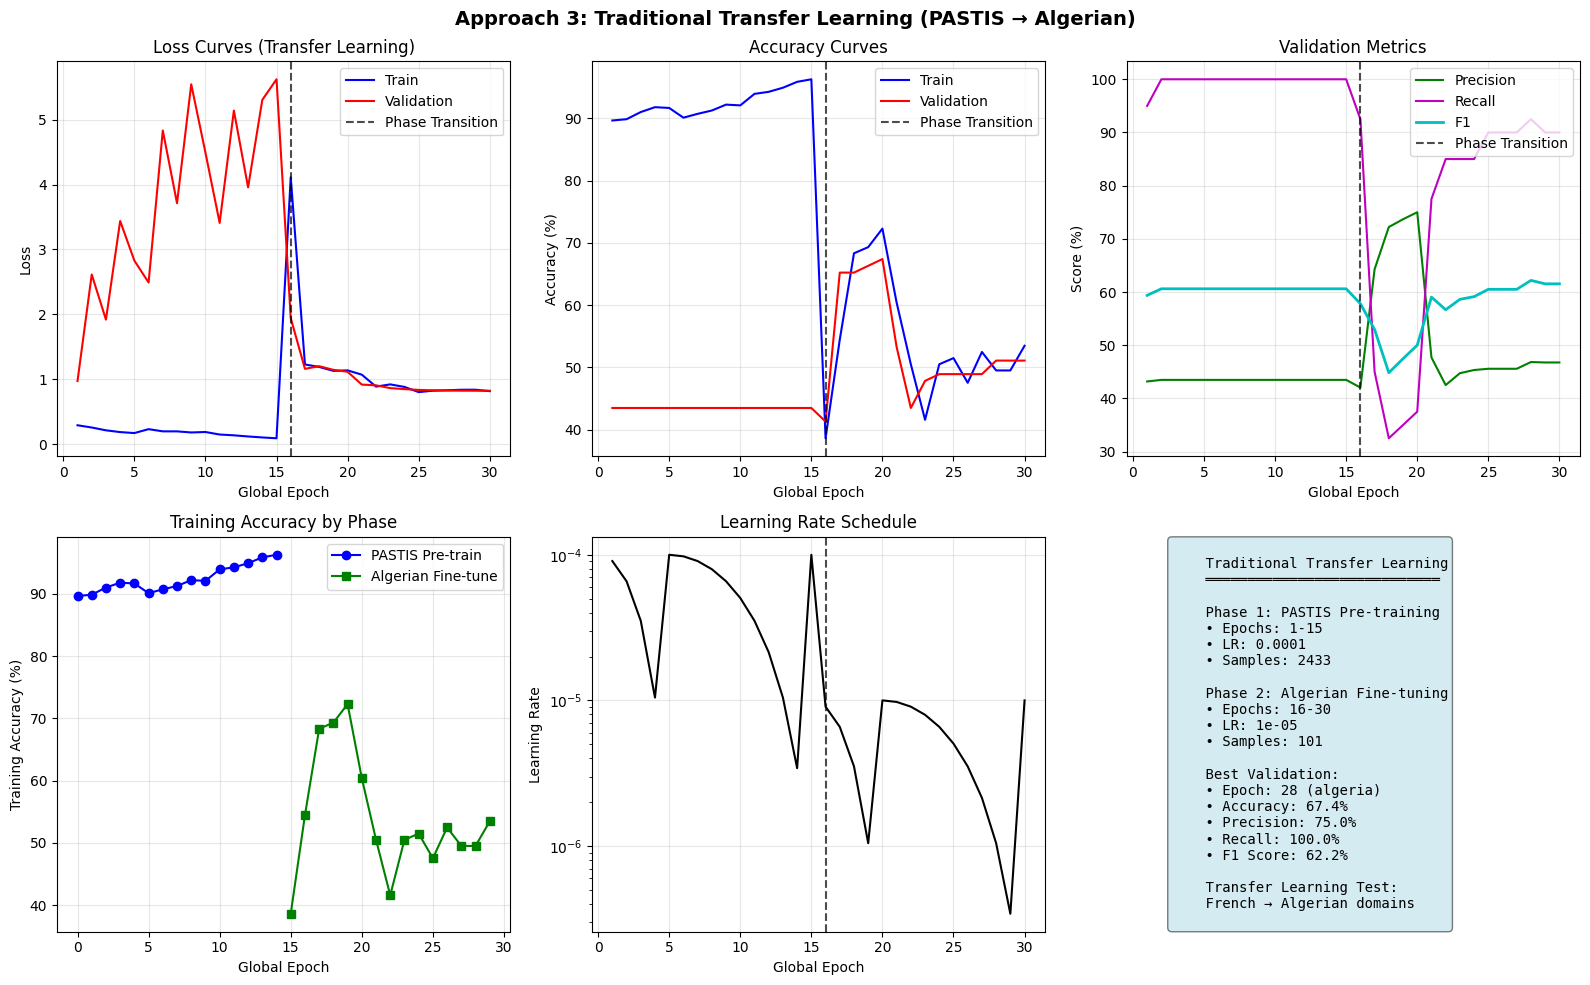

✓ Transfer learning training history saved


In [11]:
# =============================================================================
# CELL 11: Plot Transfer Learning History
# =============================================================================

def plot_transfer_learning_history(history):
    fig, axes = plt.subplots(2, 3, figsize=(16, 10))
    epochs = history['epoch']
    
    # Find phase transition
    phase_transition_idx = None
    for i, phase in enumerate(history['phase']):
        if phase == 'algeria':
            phase_transition_idx = i
            break
    
    # Loss
    axes[0, 0].plot(epochs, history['train_loss'], 'b-', label='Train')
    axes[0, 0].plot(epochs, history['val_loss'], 'r-', label='Validation')
    if phase_transition_idx:
        axes[0, 0].axvline(x=phase_transition_idx+1, color='k', linestyle='--', alpha=0.7, label='Phase Transition')
    axes[0, 0].set_xlabel('Global Epoch')
    axes[0, 0].set_ylabel('Loss')
    axes[0, 0].set_title('Loss Curves (Transfer Learning)')
    axes[0, 0].legend()
    axes[0, 0].grid(True, alpha=0.3)
    
    # Accuracy
    axes[0, 1].plot(epochs, [a*100 for a in history['train_acc']], 'b-', label='Train')
    axes[0, 1].plot(epochs, [a*100 for a in history['val_acc']], 'r-', label='Validation')
    if phase_transition_idx:
        axes[0, 1].axvline(x=phase_transition_idx+1, color='k', linestyle='--', alpha=0.7, label='Phase Transition')
    axes[0, 1].set_xlabel('Global Epoch')
    axes[0, 1].set_ylabel('Accuracy (%)')
    axes[0, 1].set_title('Accuracy Curves')
    axes[0, 1].legend()
    axes[0, 1].grid(True, alpha=0.3)
    
    # Precision/Recall/F1
    axes[0, 2].plot(epochs, [p*100 for p in history['val_precision']], 'g-', label='Precision')
    axes[0, 2].plot(epochs, [r*100 for r in history['val_recall']], 'm-', label='Recall')
    axes[0, 2].plot(epochs, [f*100 for f in history['val_f1']], 'c-', label='F1', linewidth=2)
    if phase_transition_idx:
        axes[0, 2].axvline(x=phase_transition_idx+1, color='k', linestyle='--', alpha=0.7, label='Phase Transition')
    axes[0, 2].set_xlabel('Global Epoch')
    axes[0, 2].set_ylabel('Score (%)')
    axes[0, 2].set_title('Validation Metrics')
    axes[0, 2].legend()
    axes[0, 2].grid(True, alpha=0.3)
    
    # Phase-specific plots
    pastis_epochs = [i for i, p in enumerate(history['phase']) if p == 'pastis']
    algeria_epochs = [i for i, p in enumerate(history['phase']) if p == 'algeria']
    
    # Training accuracy by phase
    axes[1, 0].plot(pastis_epochs, [history['train_acc'][i]*100 for i in pastis_epochs], 
                   'b-', label='PASTIS Pre-train', marker='o')
    axes[1, 0].plot(algeria_epochs, [history['train_acc'][i]*100 for i in algeria_epochs], 
                   'g-', label='Algerian Fine-tune', marker='s')
    axes[1, 0].set_xlabel('Global Epoch')
    axes[1, 0].set_ylabel('Training Accuracy (%)')
    axes[1, 0].set_title('Training Accuracy by Phase')
    axes[1, 0].legend()
    axes[1, 0].grid(True, alpha=0.3)
    
    # Learning Rate
    axes[1, 1].plot(epochs, history['lr'], 'k-')
    if phase_transition_idx:
        axes[1, 1].axvline(x=phase_transition_idx+1, color='k', linestyle='--', alpha=0.7, label='Phase Transition')
    axes[1, 1].set_xlabel('Global Epoch')
    axes[1, 1].set_ylabel('Learning Rate')
    axes[1, 1].set_title('Learning Rate Schedule')
    axes[1, 1].set_yscale('log')
    axes[1, 1].grid(True, alpha=0.3)
    
    # Summary
    axes[1, 2].axis('off')
    best_epoch = np.argmax(history['val_f1']) + 1
    phase_at_best = history['phase'][best_epoch-1]
    
    summary_text = f"""
    Traditional Transfer Learning
    ════════════════════════════

    Phase 1: PASTIS Pre-training
    • Epochs: 1-{CONFIG['pastis_epochs']}
    • LR: {CONFIG['pastis_lr']}
    • Samples: {len(pastis_dataset)}

    Phase 2: Algerian Fine-tuning
    • Epochs: {CONFIG['pastis_epochs']+1}-{len(epochs)}
    • LR: {CONFIG['finetune_lr']}
    • Samples: {len(algeria_train_dataset)}

    Best Validation:
    • Epoch: {best_epoch} ({phase_at_best})
    • Accuracy: {max(history['val_acc'])*100:.1f}%
    • Precision: {max(history['val_precision'])*100:.1f}%
    • Recall: {max(history['val_recall'])*100:.1f}%
    • F1 Score: {max(history['val_f1'])*100:.1f}%

    Transfer Learning Test:
    French → Algerian domains
    """
    axes[1, 2].text(0.1, 0.5, summary_text, transform=axes[1, 2].transAxes,
                    fontsize=10, verticalalignment='center', fontfamily='monospace',
                    bbox=dict(boxstyle='round', facecolor='lightblue', alpha=0.5))
    
    plt.suptitle('Approach 3: Traditional Transfer Learning (PASTIS → Algerian)', fontsize=14, fontweight='bold')
    plt.tight_layout()
    plt.savefig('/home/crop/Desktop/crop2/output/transfer_learning_history.png', dpi=150, bbox_inches='tight')
    plt.show()
    
    print("✓ Transfer learning training history saved")

# Plot results
plot_transfer_learning_history(history)

In [12]:
# =============================================================================
# CELL 12: Final Evaluation
# =============================================================================

def evaluate_model(model, val_loader, device, threshold=0.5):
    model.eval()
    all_preds = []
    all_labels = []
    all_probs = []
    
    with torch.no_grad():
        for imgs, labels in val_loader:
            imgs = imgs.to(device)
            outputs = model(imgs)
            probs = torch.sigmoid(outputs).cpu().numpy().flatten()
            preds = (probs > threshold).astype(float)
            
            all_probs.extend(probs)
            all_preds.extend(preds)
            all_labels.extend(labels.numpy())
    
    all_preds = np.array(all_preds)
    all_labels = np.array(all_labels)
    all_probs = np.array(all_probs)
    
    tp = ((all_preds == 1) & (all_labels == 1)).sum()
    fp = ((all_preds == 1) & (all_labels == 0)).sum()
    fn = ((all_preds == 0) & (all_labels == 1)).sum()
    tn = ((all_preds == 0) & (all_labels == 0)).sum()
    
    accuracy = (all_preds == all_labels).mean()
    precision = tp / max(tp + fp, 1)
    recall = tp / max(tp + fn, 1)
    f1 = 2 * precision * recall / max(precision + recall, 1e-8)
    
    return {
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'f1': f1,
        'confusion': (tp, fp, fn, tn),
        'predictions': all_preds,
        'labels': all_labels,
        'probabilities': all_probs
    }

# Evaluate
print("Final Evaluation - Traditional Transfer Learning")
print("=" * 70)

results = evaluate_model(model, algeria_val_loader, device, threshold=CONFIG['prediction_threshold'])

print(f"Accuracy:  {results['accuracy']*100:.1f}%")
print(f"Precision: {results['precision']*100:.1f}%")
print(f"Recall:    {results['recall']*100:.1f}%")
print(f"F1 Score:  {results['f1']*100:.1f}%")

tp, fp, fn, tn = results['confusion']
print(f"\nConfusion Matrix:")
print(f"                  Predicted")
print(f"                  Non-Cereal  Cereal")
print(f"Actual Non-Cereal    {tn:4d}      {fp:4d}")
print(f"Actual Cereal        {fn:4d}      {tp:4d}")

print(f"\n⚠️  TRADITIONAL TRANSFER LEARNING PERFORMANCE:")
print(f"   Phase 1: Pre-trained on {len(pastis_dataset)} PASTIS samples (French)")
print(f"   Phase 2: Fine-tuned on {len(algeria_train_dataset)} Algerian samples")
print(f"   Tested on {len(algeria_val_dataset)} Algerian validation samples")
print(f"   Domain transfer: French spectral characteristics → Algerian domain")

Final Evaluation - Traditional Transfer Learning
Accuracy:  51.1%
Precision: 46.8%
Recall:    90.0%
F1 Score:  61.5%

Confusion Matrix:
                  Predicted
                  Non-Cereal  Cereal
Actual Non-Cereal      11        41
Actual Cereal           4        36

⚠️  TRADITIONAL TRANSFER LEARNING PERFORMANCE:
   Phase 1: Pre-trained on 2433 PASTIS samples (French)
   Phase 2: Fine-tuned on 101 Algerian samples
   Tested on 92 Algerian validation samples
   Domain transfer: French spectral characteristics → Algerian domain


In [13]:
# =============================================================================
# CELL 13: Save Model
# =============================================================================

checkpoint_path = Path('/home/crop/Desktop/crop2/output/transfer_learning_cereal_classifier.pth')

checkpoint = {
    'model_state_dict': model.state_dict(),
    'config': CONFIG,
    'history': history,
    'best_f1': best_f1,
    'results': {
        'accuracy': results['accuracy'],
        'precision': results['precision'],
        'recall': results['recall'],
        'f1': results['f1'],
        'confusion': results['confusion']
    },
    'approach': 'transfer_learning_pastis_to_algeria'
}

torch.save(checkpoint, checkpoint_path)
print(f"✓ Transfer learning model saved to: {checkpoint_path}")
print(f"  File size: {checkpoint_path.stat().st_size / 1e6:.1f} MB")
print(f"  Approach: Traditional Transfer Learning (PASTIS → Algerian)")
print(f"  Phase 1 epochs: {CONFIG['pastis_epochs']}")
print(f"  Phase 2 epochs: {CONFIG['finetune_epochs']}")
print(f"  Best F1: {best_f1*100:.1f}%")

✓ Transfer learning model saved to: /home/crop/Desktop/crop2/output/transfer_learning_cereal_classifier.pth
  File size: 110.2 MB
  Approach: Traditional Transfer Learning (PASTIS → Algerian)
  Phase 1 epochs: 15
  Phase 2 epochs: 15
  Best F1: 62.2%


---

## Summary - Approach 3: Traditional Transfer Learning (PASTIS → Algerian)

### What We Tested:
- **Phase 1 (Pre-training)**: 2,433 raw PASTIS samples (French domain)
- **Phase 2 (Fine-tuning)**: 101 real Algerian training samples (target domain)
- **Validation**: 92 real Algerian validation samples
- **No FDA adaptation**: Traditional transfer learning approach

### Key Differences from Approach 1:
- **Sequential training**: Pre-train → Fine-tune (vs. simultaneous hybrid training)
- **Domain order**: Source domain first, then target domain
- **Learning rates**: Higher LR for pre-training (1e-4), lower LR for fine-tuning (1e-5)
- **No domain mixing**: Pure source domain → Pure target domain

### Training Strategy:
1. **Phase 1**: Train on PASTIS data with higher learning rate to learn general features
2. **Phase 2**: Fine-tune on Algerian data with lower learning rate to adapt to target domain
3. **Validation**: Always evaluate on Algerian validation set

### Expected Results:
This approach tests traditional transfer learning effectiveness for satellite imagery domain adaptation, where we expect some domain shift but potentially better generalization than random initialization.

### Comparison with Other Approaches:
- **Approach 1**: FDA-adapted PASTIS (2,433) + Algerian (101) = domain adaptation
- **Approach 2**: Algerian only (101) = baseline with limited data
- **Approach 3**: PASTIS pre-train (2,433) → Algerian fine-tune (101) = traditional transfer

### Files Created:
- `output/transfer_learning_cereal_classifier.pth` - Transfer learning model
- `output/transfer_learning_history.png` - Training curves with phase transition
